# **Exploratory Data Analysing Using Youtube Video Data from Youtube Channels**

# **🧮Overview**
In this project, we will leverage the Google-provided YouTube API to extract statistical data from YouTube channels using Python code. We will specifically utilize the powerful features of the YouTube Data API v3, which provides a wide range of functionalities for obtaining statistics and channel information. Our goal is to demonstrate how to obtain statistical data from any YouTube channel by using either its unique username or ID through the YouTube Data API v3. This project will showcase the capabilities of the API and how it can be harnessed for data retrieval and analysis.

![](https://raw.githubusercontent.com/Kanyawee12/Data-Analysis-with-Youtube-API/main/Picture/Concept%20Project.png)

# **1. Data selection**
*  I created my own dataset using the Google Youtube Data API version 3.0. The exact steps of data creation is presented in section.

*  The dataset is a real-world dataset and suitable for the research. However, the selection of  Youtube channels to include in the research is purely based on my knowledge of the channels in data science field and might not be accurate. My definition is "popular" is only based on subscriber count but there are other metrics that could be taken into consideration as well (e.g. views, engagement).

**Ethics of data source**

According to Youtube API's guide, the usage of Youtube API is free of charge given that your application send requests within a quota limit. "The YouTube Data API uses a quota to ensure that developers use the service as intended and do not create applications that unfairly reduce service quality or limit access for others. " The default quota allocation for each application is 10,000 units per day, and you could request additional quota by completing a form to YouTube API Services if you reach the quota limit.

Since all data requested from Youtube API is public data (which everyone on the Internet can see on Youtube), there is no particular privacy issues as far as I am concerned. In addition, the data is obtained only for research purposes in this case and not for any commercial interests.

# **2. Aims and objectives**

> **Within this project, I would like to explore the following:**

  *   **Getting to know Youtube API and how to obtain video data**
    *   Does the number of likes and comments matter for a video to get more views?
    *   Does the video duration matter for views and interaction (likes/ comments)?
    *   Does title length matter for views?
    *   How many tags do good performing videos have? What are the common tags among these videos?
    *   Across all the creators I take into consideration, how often do they upload new videos? On which days in the week?


  *   **Explore the trending topics using NLP techniques**
    *   Which popular topics are being covered in the videos (e.g. using wordcloud for video titles)?

    *   Which questions are being asked in the comment sections in the videos






# **3. Steps of the project**
1.   Obtain video meta data via Youtube API for the top 10-15 channels in the data science niche (this includes several small steps: create a developer key, request data and transform the responses into a usable data format)
2.   Prepocess data and engineer additional features for analysis
3.   Exploratory data analysis
4.   Conclusions


# Importing Libraries

In [1]:
# Intro to data structures
import numpy as np
import pandas as pd
from IPython.display import JSON

# googleapiclient
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

# data visualization packet
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

# NLP
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from nltk.corpus import words

# warnings = ignore
import warnings
warnings.filterwarnings("ignore")

# Data creation with Youtube API

I began by obtaining the necessary authorization credential, an API key, from Google Cloud. This API key serves as the gateway to interact securely with Google's services. Following that, I activated the YouTube API for my application, granting it the required permissions to send API requests to YouTube's extensive suite of services. This project revolves around the effective utilization of the YouTube API to access and analyze channel statistics, ultimately enhancing our understanding of the performance and impact of the selected channels.

In [2]:
api_key = 'XXXX'

In [3]:
channel_ids = ['UCV8e2g4IWQqK71bbzGDEI4Q',
              # more chanel here
             ]

In [4]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey = api_key)


## **Get channel statisticst**

Defines a function called `get_channel_stats` that uses the YouTube Data API to retrieve statistics for a list of YouTube channels identified by their channel IDs.  This function allows you to retrieve statistics for multiple YouTube channels using their channel IDs and organize the data into a structured DataFrame for further analysis.
*   **`youtube`**: This parameter is expected to be an instance of the YouTube Data API client, which is used to make API requests to retrieve channel information.
*   **`channel_ids`**: This is a list of YouTube channel IDs for which you want to retrieve statistics and information.

**Here's what each piece of information represents:**

*  `channelName`: The title of the YouTube channel, extracted from the snippet part of the API response.
*  `subscribers`: The number of subscribers to the channel, extracted from the statistics part of the API response.
*  `view`: The total number of views on the channel, also extracted from the statistics part.
*  `totalVideos`: The total number of videos uploaded to the channel, again extracted from the statistics part.
*  `playlistId`: The ID of the playlist containing the channel's uploads, extracted from the contentDetails part.


In [5]:
def get_channel_stats(youtube, channel_ids):
    all_data = []

    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
    #     this is to concatenate all the channel ids together
        id=','.join(channel_ids)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {'channelName' : item['snippet']['title'],
                'subscribers' : item['statistics']['subscriberCount'],
                'view' : item['statistics']['viewCount'],
                'totalVideos' : item['statistics']['videoCount'],
                'playlistId' : item['contentDetails']['relatedPlaylists']['uploads']
               }
        all_data.append(data)

    return pd.DataFrame(all_data)

In [6]:
chanel_stats = get_channel_stats(youtube, channel_ids)

In [7]:
chanel_stats

,channelName,subscribers,view,totalVideos,playlistId
0,Data Professor,163000,5048669,322,UUV8e2g4IWQqK71bbzGDEI4Q


This Python code defines a function called `get_video_ids` that is used to retrieve a list of video IDs from a YouTube playlist using the YouTube Data API.
*   **`youtube`**: This parameter is expected to be an instance of the YouTube Data API client, which is used to make API requests to retrieve channel information.
*   **`playlist_Id`**: This is the ID of the playlist from which you want to retrieve video IDs.

Remark:

*  **maxResults** = 50: This parameter specifies that data for up to 50 videos will be fetched in each API request. This is the maximum number of results allowed per request according to the API's limitations.
*  **nextPageToken**: This is used for pagination. If a playlist has more than 50 videos, you need to use this token to retrieve data from the next page of results.
The code uses a while loop for pagination. It continues to fetch data from the next page until there are no more pages (when nextPageToken becomes None).

The result obtained is a list of video IDs (video_ids) from the specified playlist, which can be used for further data retrieval or analysis.

In [8]:
playlist_Id='UUV8e2g4IWQqK71bbzGDEI4Q'

def get_video_ids(youtube, playlist_id):

    video_ids = []

    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')

    return video_ids

In [9]:
video_ids = get_video_ids(youtube,playlist_Id)

In [10]:
len(video_ids)

323

This Python function `get_video_details` is designed to fetch details about a list of YouTube videos using the YouTube Data API. Specifically, it fetches details like the video's title, description, statistics, and other attributes, and then stores this information in a pandas DataFrame before returning it.
*  **`youtube`**: A reference to the initialized YouTube Data API client.
*  **`video_ids`**: A list of video IDs for which to fetch details.
  *  The function processes the **`video_ids`** list 50 IDs at a time (YouTube API allows up to 50 video IDs per request). The for loop takes slices of up to 50 video IDs and fetches details for those videos.
* This dictionary specifies which attributes to fetch for each video:
  *  snippet: Includes channelTitle, title, description, tags, and publishedAt.
  *  statistics: Includes viewCount, likeCount, favouriteCount, and commentCount.
  *  contentDetails: Includes duration, definition, and caption.

In [11]:
def get_video_details(youtube, video_ids):

    all_video_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favoriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)

    return pd.DataFrame(all_video_info)

In [12]:
video_df = get_video_details(youtube, video_ids)

In [13]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favoriteCount,commentCount,duration,definition,caption
0,pT3kE5hExGc,Data Professor,Streamlit LLM Hackathon,If large language models and generative AI sou...,None,2023-09-08T09:10:04Z,4018,89,0,10,PT3M27S,hd,false
1,T_iE6TT7pS8,Data Professor,How to Use the Open-Source Hugging Chat API in...,"In this video, you'll learn how to use the uno...","[huggingchat, hugging chat, hugging chat api, ...",2023-08-28T05:05:38Z,2021,70,0,14,PT7M38S,hd,false
2,kvJf8s18Vr4,Data Professor,How to use GitHub Codespaces for Coding and Da...,"In this video, you'll learn how to use GitHub ...","[GitHub, GitHub Codespaces, GitHub tutorial, S...",2023-08-21T01:00:30Z,3001,141,0,8,PT11M53S,hd,false
3,Lxj4GfJCvxA,Data Professor,Introducing the Mito Streamlit component,"In this video, Jake (co-founder of Mito, a Y C...","[mito, streamlit component, mito streamlit com...",2023-08-14T07:29:14Z,1111,37,0,4,PT4M32S,hd,false
4,dBoQLktIkOo,Data Professor,How to use the Llama 2 LLM in Python,"In this video, you'll learn how to use the Lla...",None,2023-08-01T03:23:49Z,25310,359,0,23,PT4M51S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,uoVAd_zd-90,Data Professor,Computational Drug Discovery: Machine Learning...,"In this lecture, I provide an overview on how ...","[data science, big data, bioinformatics, bioin...",2019-10-02T12:32:13Z,26209,767,0,70,PT2H22M7S,hd,false
319,77ggqTODduQ,Data Professor,WEKA Tutorial #1.3 - How to Build a Data Minin...,"In this Part 3 video (of a 3 part series), we’...","[tutorial, learn, how to, concept, WEKA, from ...",2019-09-07T14:57:40Z,3517,61,0,12,PT3M36S,hd,true
320,U_WEKreNuA4,Data Professor,WEKA Tutorial #1.2 - How to Build a Data Minin...,"In this Part 2 video (of a 3 part series), we ...","[tutorial, learn, how to, concept, WEKA, from ...",2019-09-01T14:46:38Z,7736,112,0,9,PT13M43S,hd,true
321,GzrmsiBsGVI,Data Professor,WEKA Tutorial #1.1 - How to Build a Data Minin...,"In this Part 1 video (of a 3 part series), you...","[tutorial, learn, how to, concept, WEKA, from ...",2019-08-29T17:51:45Z,15792,243,0,11,PT9M21S,hd,true



The function `get_comment_in_video` fetches the comments for a list of YouTube videos using the YouTube Data API. Specifically, it fetches the top 10 comments for each video ID in the provided list video_ids and stores this information in a pandas DataFrame before returning it.

*  **`youtube`**: A reference to the initialized YouTube Data API client.
*  **`video_ids`**: A list of video IDs for which to fetch comments.

Finally, a pandas DataFrame is created from all_comments and returned.
In summary, this function accepts an initialized YouTube Data API client and a list of video IDs, then fetches and returns the top 10 comments for each video in a pandas DataFrame. It also handles cases where comments are disabled or other errors occur.

In [14]:
def get_comment_in_video(youtube, video_ids):
    all_comments = []

    for video_id in video_ids:
        try:
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()

            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
        except HttpError as e:
            if e.resp.status == 403:
                print(f"Comments are disabled for video ID: {video_id}")
            else:
                print(f"An error occurred for video ID: {video_id}")

    return pd.DataFrame(all_comments)


In [15]:
comments_df = get_comment_in_video(youtube, video_ids)
comments_df

Comments are disabled for video ID: 8nJvjNnONbY


,video_id,comments
0,pT3kE5hExGc,[without using a paid open AI API key we can't...
1,T_iE6TT7pS8,"[Hey, i am working on my personal project, whi..."
2,kvJf8s18Vr4,[I have GitHub student dev pack should I use t...
3,Lxj4GfJCvxA,[There are many things for which I will like t...
4,dBoQLktIkOo,"[Promo*SM, how do i get an API Key, why u make..."
...,...,...
317,uoVAd_zd-90,[Thank you Prof for sharing this video . I lov...
318,77ggqTODduQ,"[Wonderful!, Build a classification model for ..."
319,U_WEKreNuA4,"[❤️🙏🏻❤️, Please explain no. of leaves and size..."
320,GzrmsiBsGVI,[This was WAY too long. This could have effect...


**Export Pandas DataFrame to CSV for "YouTube Comments NLP Sentiment Analysis"**

In [16]:
comments_df.to_csv('comments_df.csv', index=False)

# **Data pre-processing**



## Exploratory data analysis
Exploratory Data Analysis is an audit process or explore the basics It is the necessary data analysis before using the data. Alternatively, it can be utilized for insight analysis. The advantages of EDA assist us in comprehending the fundamentals of that data set, as well as exploring the missing value and imperfection of the data set.

In [17]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323 entries, 0 to 322
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   video_id       323 non-null    object
 1   channelTitle   323 non-null    object
 2   title          323 non-null    object
 3   description    323 non-null    object
 4   tags           307 non-null    object
 5   publishedAt    323 non-null    object
 6   viewCount      323 non-null    object
 7   likeCount      323 non-null    object
 8   favoriteCount  323 non-null    object
 9   commentCount   323 non-null    object
 10  duration       323 non-null    object
 11  definition     323 non-null    object
 12  caption        323 non-null    object
dtypes: object(13)
memory usage: 32.9+ KB


**Change the type of the "viewCount" "likeCount" "commentCount" and "favoriteCount" columns from object to numeric**

In [18]:
numeric_cols = ['viewCount','likeCount','commentCount','favoriteCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [19]:
video_df.dtypes

video_id         object
channelTitle     object
title            object
description      object
tags             object
publishedAt      object
viewCount         int64
likeCount         int64
favoriteCount     int64
commentCount      int64
duration         object
definition       object
caption          object
dtype: object

**Handle Missing Values**
*  Explor missing value by dataset.isnull().sum() in dataset: column 'tags' has null values are 14 (ignore tag column)

In [20]:
video_df.isnull().sum()

video_id          0
channelTitle      0
title             0
description       0
tags             16
publishedAt       0
viewCount         0
likeCount         0
favoriteCount     0
commentCount      0
duration          0
definition        0
caption           0
dtype: int64

* Explor zero value by (video_df==0).sum() in dataset: column 'favoriteCount' has null values are 323 (columns with all Zero's)

In [21]:
video_df.describe()

,viewCount,likeCount,favoriteCount,commentCount
count,323.000000,323.000000,323.0,323.000000
mean,15636.160991,408.523220,0.0,42.461300
std,24937.573706,646.943301,0.0,41.919483
min,0.000000,0.000000,0.0,0.000000
25%,3951.000000,123.500000,0.0,17.000000
50%,8329.000000,241.000000,0.0,30.000000
75%,16206.500000,426.500000,0.0,57.500000
max,311506.000000,8738.000000,0.0,347.000000


In [22]:
zero_count_per_column = (video_df == 0).sum()
zero_count_per_column

video_id           0
channelTitle       0
title              0
description        0
tags               0
publishedAt        0
viewCount          1
likeCount          1
favoriteCount    323
commentCount       3
duration           0
definition         0
caption            0
dtype: int64

**Removing irrelevant** columns from your dataset is often one of the first steps in data cleaning and preprocessing
*  drop columns with all Zero's : favoriteCount

In [23]:
# drop columns with all Zero's : favoriteCount
nan_value = float("NaN")
video_df['favoriteCount'] = video_df['favoriteCount'].replace(0,nan_value, inplace = True)
video_df = video_df.dropna(axis=1, how='all')

In [24]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption
0,pT3kE5hExGc,Data Professor,Streamlit LLM Hackathon,If large language models and generative AI sou...,None,2023-09-08T09:10:04Z,4018,89,10,PT3M27S,hd,false
1,T_iE6TT7pS8,Data Professor,How to Use the Open-Source Hugging Chat API in...,"In this video, you'll learn how to use the uno...","[huggingchat, hugging chat, hugging chat api, ...",2023-08-28T05:05:38Z,2021,70,14,PT7M38S,hd,false
2,kvJf8s18Vr4,Data Professor,How to use GitHub Codespaces for Coding and Da...,"In this video, you'll learn how to use GitHub ...","[GitHub, GitHub Codespaces, GitHub tutorial, S...",2023-08-21T01:00:30Z,3001,141,8,PT11M53S,hd,false
3,Lxj4GfJCvxA,Data Professor,Introducing the Mito Streamlit component,"In this video, Jake (co-founder of Mito, a Y C...","[mito, streamlit component, mito streamlit com...",2023-08-14T07:29:14Z,1111,37,4,PT4M32S,hd,false
4,dBoQLktIkOo,Data Professor,How to use the Llama 2 LLM in Python,"In this video, you'll learn how to use the Lla...",None,2023-08-01T03:23:49Z,25310,359,23,PT4M51S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...
318,uoVAd_zd-90,Data Professor,Computational Drug Discovery: Machine Learning...,"In this lecture, I provide an overview on how ...","[data science, big data, bioinformatics, bioin...",2019-10-02T12:32:13Z,26209,767,70,PT2H22M7S,hd,false
319,77ggqTODduQ,Data Professor,WEKA Tutorial #1.3 - How to Build a Data Minin...,"In this Part 3 video (of a 3 part series), we’...","[tutorial, learn, how to, concept, WEKA, from ...",2019-09-07T14:57:40Z,3517,61,12,PT3M36S,hd,true
320,U_WEKreNuA4,Data Professor,WEKA Tutorial #1.2 - How to Build a Data Minin...,"In this Part 2 video (of a 3 part series), we ...","[tutorial, learn, how to, concept, WEKA, from ...",2019-09-01T14:46:38Z,7736,112,9,PT13M43S,hd,true
321,GzrmsiBsGVI,Data Professor,WEKA Tutorial #1.1 - How to Build a Data Minin...,"In this Part 1 video (of a 3 part series), you...","[tutorial, learn, how to, concept, WEKA, from ...",2019-08-29T17:51:45Z,15792,243,11,PT9M21S,hd,true


**Publish day in week convert of 'publishedAt' column from object to datetime.**

In [25]:
from dateutil import parser

In [26]:
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))

In [27]:
video_df['publishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime('%A'))

In [28]:
# Comments and likes per 1000 view ratio
video_df['likeRatio'] = video_df['likeCount'] / video_df['viewCount'] *1000
video_df['commentRatio'] = video_df['commentCount']/video_df['viewCount'] *1000

In [29]:
video_df[['publishedAt','publishDayName']]

,publishedAt,publishDayName
0,2023-09-08 09:10:04+00:00,Friday
1,2023-08-28 05:05:38+00:00,Monday
2,2023-08-21 01:00:30+00:00,Monday
3,2023-08-14 07:29:14+00:00,Monday
4,2023-08-01 03:23:49+00:00,Tuesday
...,...,...
318,2019-10-02 12:32:13+00:00,Wednesday
319,2019-09-07 14:57:40+00:00,Saturday
320,2019-09-01 14:46:38+00:00,Sunday
321,2019-08-29 17:51:45+00:00,Thursday


To convert the "duration" column in a pandas DataFrame containing YouTube video data from the "PTXHXMXS" format to seconds, you can use the apply function along with the youtube_duration_to_seconds function that we defined earlier. Here's how you can do it:

In [30]:
import re

In [31]:
def youtube_covert_duration_to_sec(duration_str):
    pattern = re.compile(r'PT(\d+H)?(\d+M)?(\d+S)?')
    match = pattern.match(duration_str)

    if match:
        hours = int(match.group(1)[:-1]) if match.group(1) else 0
        minutes = int(match.group(2)[:-1]) if match.group(2) else 0
        seconds = int(match.group(3)[:-1]) if match.group(3) else 0

        total_sec = hours * 3600 + minutes * 60 + seconds

        return total_sec
    else:
        return 0


In [32]:
video_df['duration_sec'] = video_df['duration'].apply(youtube_covert_duration_to_sec)

In [33]:
video_df[['duration_sec','duration']]

,duration_sec,duration
0,207,PT3M27S
1,458,PT7M38S
2,713,PT11M53S
3,272,PT4M32S
4,291,PT4M51S
...,...,...
318,8527,PT2H22M7S
319,216,PT3M36S
320,823,PT13M43S
321,561,PT9M21S


In [34]:
# Add tag count
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [35]:
video_df[['tagsCount','tags']]

,tagsCount,tags
0,0,None
1,20,"[huggingchat, hugging chat, hugging chat api, ..."
2,12,"[GitHub, GitHub Codespaces, GitHub tutorial, S..."
3,22,"[mito, streamlit component, mito streamlit com..."
4,0,None
...,...,...
318,32,"[data science, big data, bioinformatics, bioin..."
319,21,"[tutorial, learn, how to, concept, WEKA, from ..."
320,22,"[tutorial, learn, how to, concept, WEKA, from ..."
321,22,"[tutorial, learn, how to, concept, WEKA, from ..."


## Data visualization

**Best performing video**

                                                                                           title  viewCount
                  How to Build Your First Data Science Web App in Python - Streamlit Tutorial #1     311506
                   Web Apps in R: Building your First Web Application in R | Shiny Tutorial Ep 1     116780
Bioinformatics Project from Scratch - Drug Discovery Part 1 (Data Collection and Pre-Processing)     113065
                                  Machine Learning in Python: Building a Linear Regression Model     106578
                                    The Art of Learning Data Science (How to learn data science)      96416
                                                             How to summarize text using ChatGPT      87855
                                     Machine Learning in Python: Building a Classification Model      84901
                                               Build your first machine learning model in Python      83068
                           H

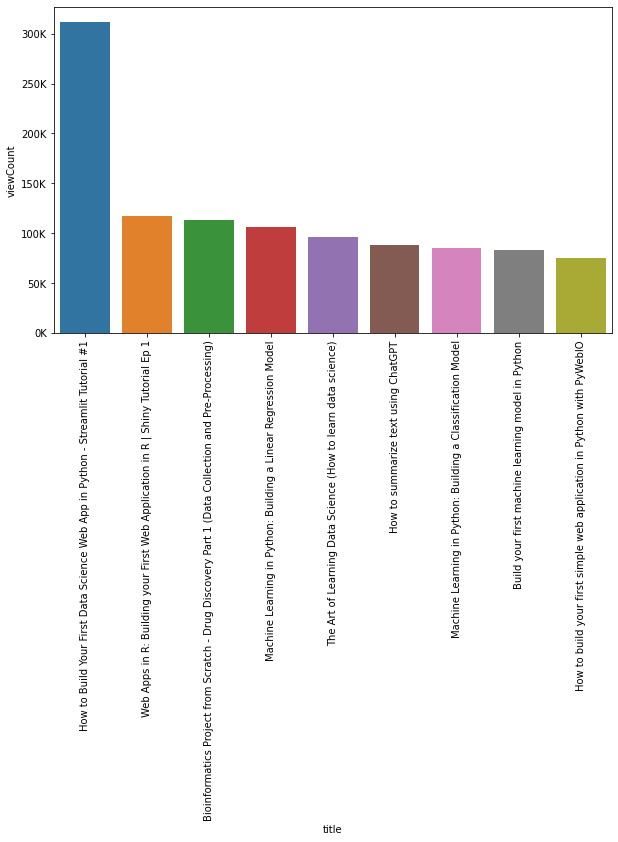

In [86]:
# Sort the DataFrame by 'viewCount' in descending order and select the top 10 best performing video rows
top_10_Bestvideos = video_df.sort_values(by='viewCount', ascending=False).head(10)
print(top_10_Bestvideos[['title','viewCount']].to_string(index=False))

plt.figure(figsize=(10,6))
ax = sns.barplot(x='title', y='viewCount', data=video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

**Worst performing video**

                                                                 title  viewCount
                                            Data Professor Live Stream          0
                                Quotes #4 on Big Data and Data Science        438
                                Quotes #5 on Big Data and Data Science        455
                                Quotes #3 on Big Data and Data Science        481
                                Quotes #2 on Big Data and Data Science        661
Advice on breaking into Tech from a FAANG Developer (@CodewithVincent)        976
                    Introducing the Cloud Dataholics sitcom by AtScale       1085
                              Introducing the Mito Streamlit component       1111
                Identifying the PROBLEM to solve when learning to CODE       1144
                               Ask Me Anything About Bioinformatics #3       1176


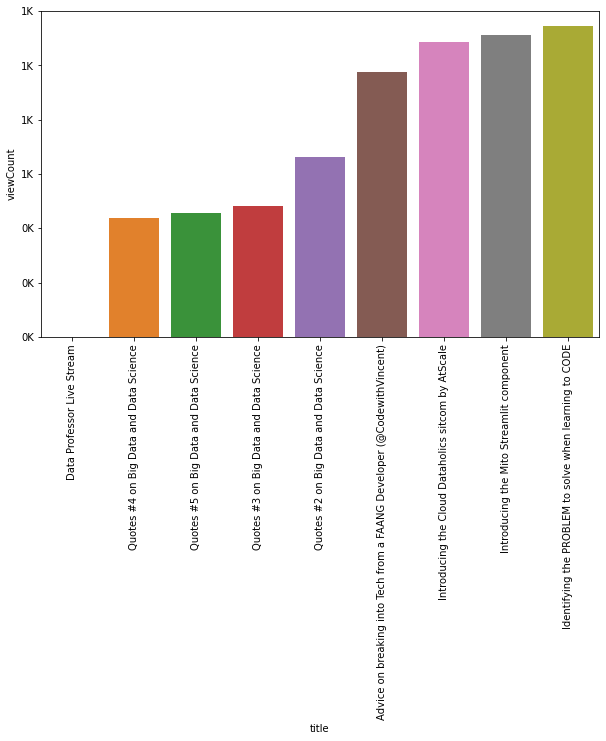

In [85]:
top_10_Worstvideos = video_df.sort_values(by ='viewCount', ascending=True).head(10)
print(top_10_Worstvideos[['title', 'viewCount']].to_string(index=False))
plt.figure(figsize=(10,6))
ax = sns.barplot(x='title', y='viewCount', data=video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

In [112]:
day_df = pd.DataFrame(video_df['publishDayName'].value_counts())
# Reset the index of day_df to make 'publishDayName' a column
day_df.reset_index(inplace=True)

In [111]:
day_df

,index,publishDayName
0,Friday,56
1,Saturday,54
2,Wednesday,46
3,Tuesday,45
4,Sunday,45
5,Monday,40
6,Thursday,37


**Which day in the week are most videos uploaded?**

It's interesting to see that on Friday and Saturday, there are more videos posted. There are fewer videos uploaded on Monday through Thursday and on Sunday.

Friday       56
Saturday     54
Wednesday    46
Tuesday      45
Sunday       45
Monday       40
Thursday     37
Name: publishDayName, dtype: int64


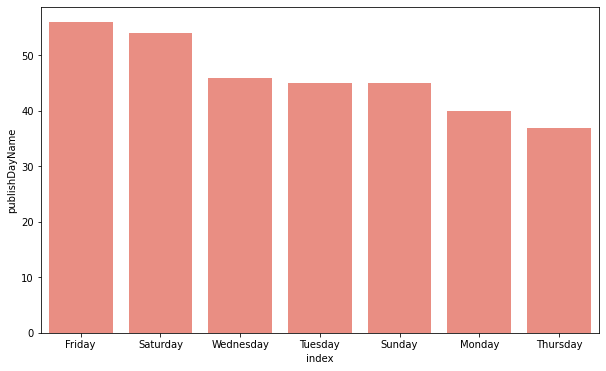

In [113]:
print(video_df.publishDayName.value_counts())
plt.figure(figsize=(10,6))
ax = sns.barplot(x = 'index', y = 'publishDayName', data = day_df, color = 'salmon')

**View distribution per video**

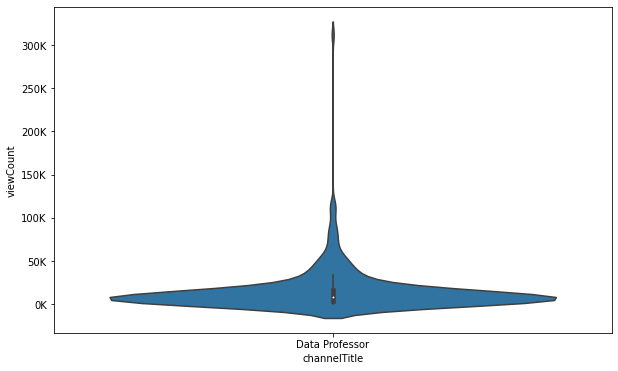

In [40]:
plt.figure(figsize=(10,6))
ax = sns.violinplot(x = 'channelTitle',y = 'viewCount', data = video_df)
ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

**Video duration**

<AxesSubplot:xlabel='duration_sec', ylabel='Count'>

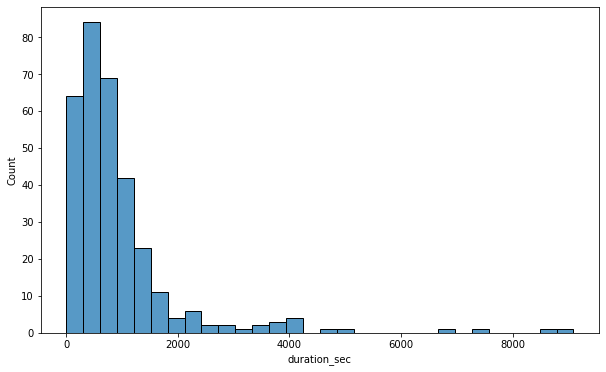

In [41]:
plt.figure(figsize=(10,6))
sns.histplot(data = video_df, x='duration_sec', bins=30)

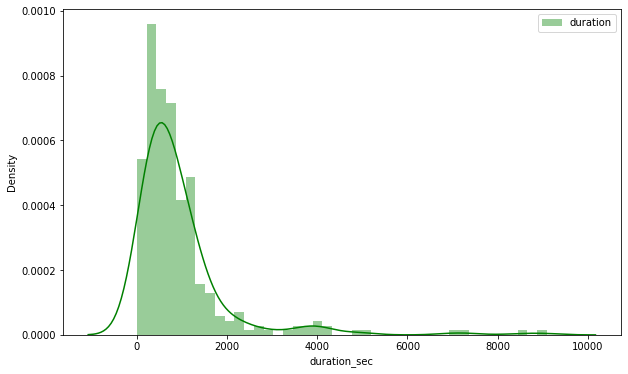

In [42]:
fig = plt.figure(figsize=(10,6))
sns.distplot(video_df.duration_sec, color="green", label="duration", kde= True)
plt.legend()

**Comparison of comments with views and likes**

<AxesSubplot:xlabel='viewCount', ylabel='likeCount'>

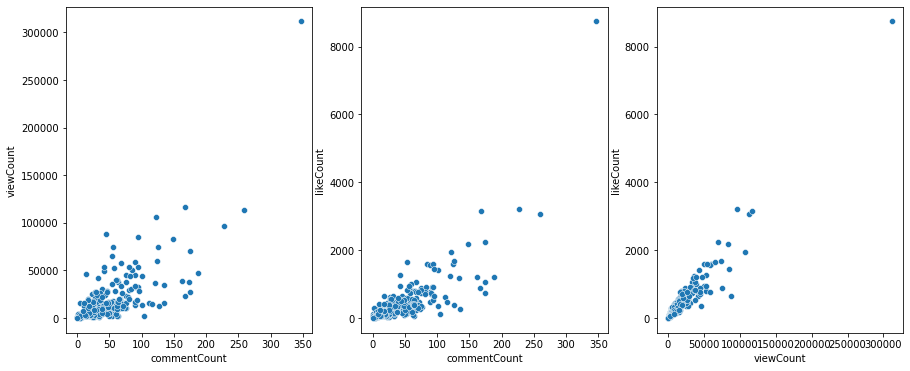

In [43]:
fig, ax = plt.subplots(1,3, figsize=(15, 6))
sns.scatterplot(x='commentCount',y='viewCount', data = video_df, ax=ax[0])
sns.scatterplot(x='commentCount', y= 'likeCount', data = video_df, ax=ax[1])
sns.scatterplot(x='viewCount', y= 'likeCount', data = video_df, ax=ax[2])

**Pair Plot**

<Figure size 720x720 with 0 Axes>

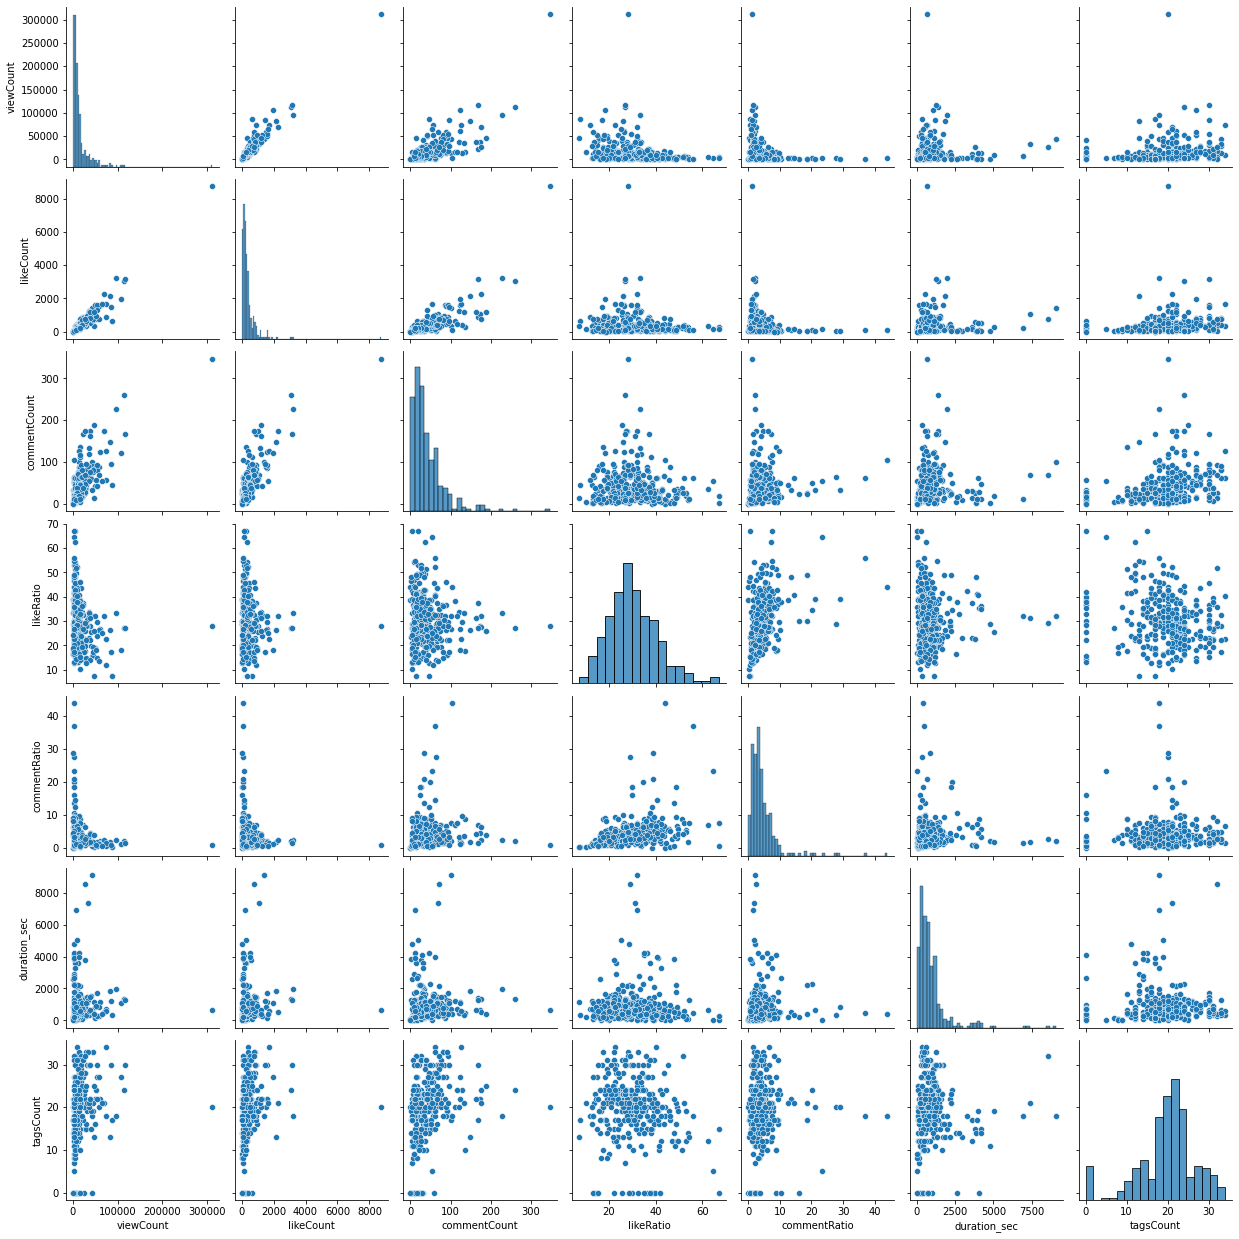

In [44]:
fig = plt.figure(figsize=(10,10))
sns.pairplot(video_df)
plt.show()

**Lable encoding**

In [45]:
video_df.dtypes

video_id                           object
channelTitle                       object
title                              object
description                        object
tags                               object
publishedAt       datetime64[ns, tzutc()]
viewCount                           int64
likeCount                           int64
commentCount                        int64
duration                           object
definition                         object
caption                            object
publishDayName                     object
likeRatio                         float64
commentRatio                      float64
duration_sec                        int64
tagsCount                           int64
dtype: object

In [46]:
video_df_1 = video_df[['viewCount','likeCount','commentCount','duration_sec','publishDayName','tagsCount']]

In [47]:
video_df_1

,viewCount,likeCount,commentCount,duration_sec,publishDayName,tagsCount
0,4018,89,10,207,Friday,0
1,2021,70,14,458,Monday,20
2,3001,141,8,713,Monday,12
3,1111,37,4,272,Monday,22
4,25310,359,23,291,Tuesday,0
...,...,...,...,...,...,...
318,26209,767,70,8527,Wednesday,32
319,3517,61,12,216,Saturday,21
320,7736,112,9,823,Sunday,22
321,15792,243,11,561,Thursday,22


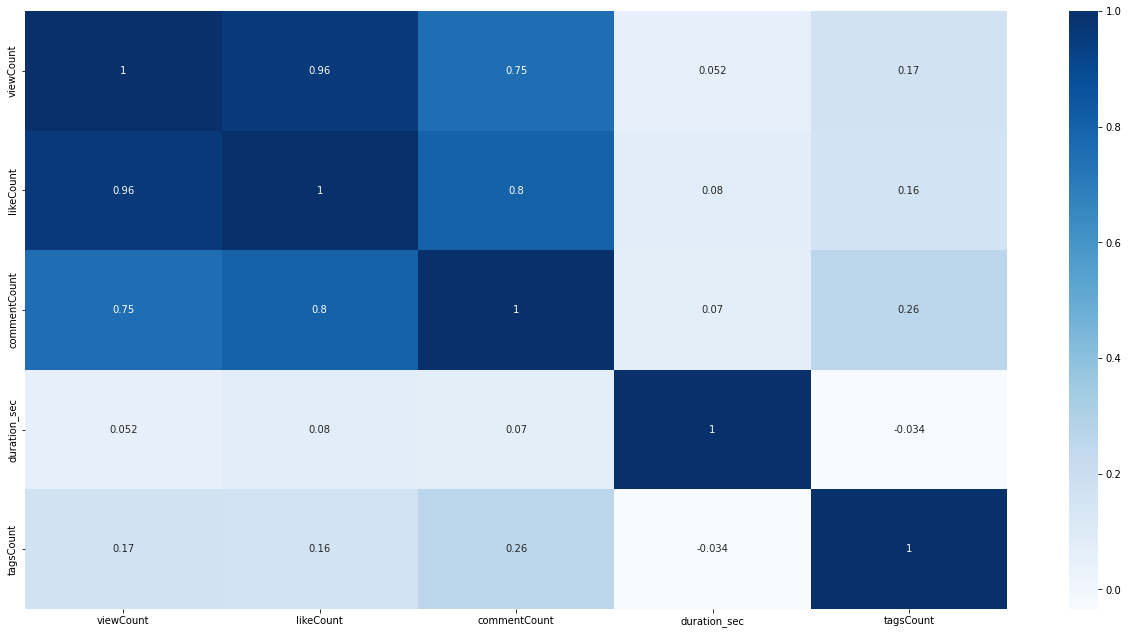

In [48]:
plt.figure(figsize=(22,11))
sns.heatmap(video_df_1.corr(),cmap='Blues',annot=True);

In [49]:
import pandas_profiling

#descriptive statistics
pandas_profiling.ProfileReport(video_df_1)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Wordcolund for video title**

In [50]:
# สร้างฟังก์ชันเพื่อกรองคำที่ไม่ใช่ภาษาอังกฤษ
def filter_non_english_words(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() in english_words]
    return ' '.join(filtered_words)

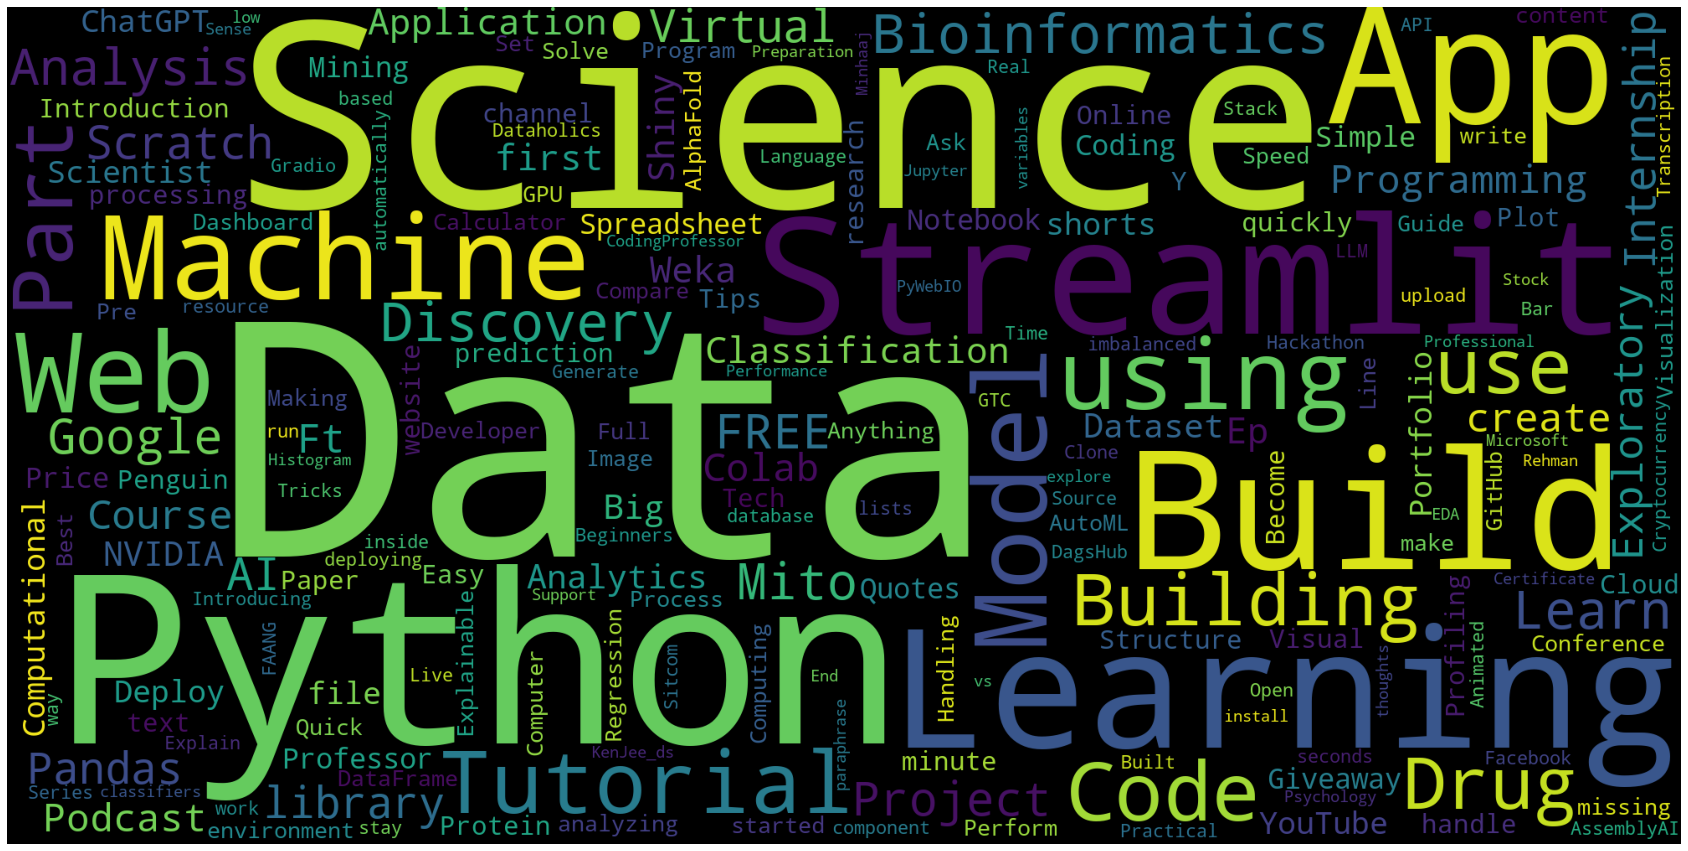

In [51]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black',
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)